In [28]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import matplotlib.pyplot as plt, argparse, numpy as np, math, sys, copy
from skimage.segmentation import slic, mark_boundaries, felzenszwalb
from skimage.util import img_as_float
from skimage import io
import numpy as np
import superpixels as sp
import plot as pl
import process_ground_truth as pgt
import glob
import eval_boundary as ev
import pipeline as pipe
import time
import superpixels as sp
import scipy.stats as sci

In [30]:
ground_path = 'BSDS500/data/groundTruth/val/'
train_path = 'BSDS500/data/images/val/'
save_path = 'save/gslic/'
bound_prefix = save_path + 'images/'
eval_prefix = save_path + 'eval/'
extension = '.npz'

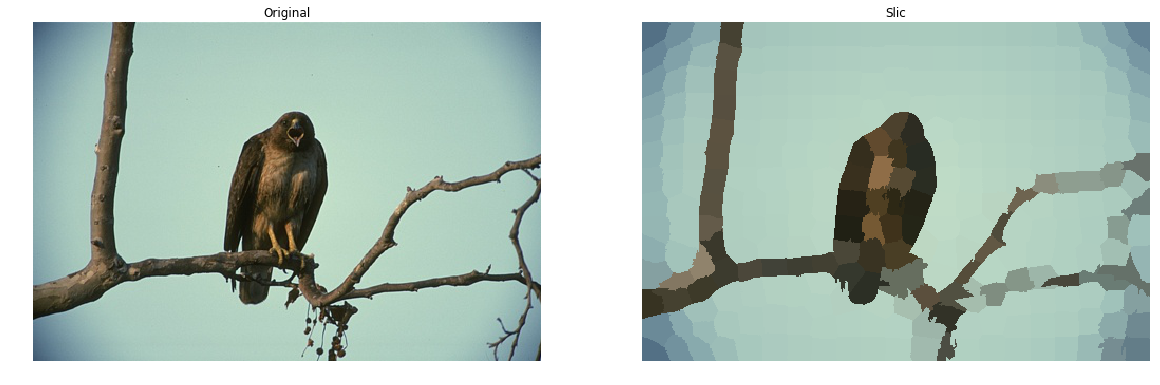

In [34]:
imagePath = 'BSDS500/data/images/val/' #'images/'
imageFile = '42049.jpg' #'3063.jpg'

image = img_as_float(io.imread((imagePath + imageFile)))

seg_slic = slic(image, n_segments = 300, slic_zero = True)
s_image, n_segs, colors = sp.color_superpixel(image, seg_slic)

fig, (ax2, ax3) = plt.subplots(1,2, figsize=(20, 20))
ax2.imshow(image)
ax2.set_title("Original")
ax2.set_axis_off()
ax3.imshow(s_image)
ax3.set_title("Slic")
ax3.set_axis_off()
plt.show() 

In [35]:
img = np.zeros(image.shape,dtype=np.uint8) #create blank image to save
img.fill(255)

ultra_image, cluster_sizes = pipe.generate_ultrametric_image(image, img, method = 'hegb')

print(cluster_sizes)

[163, 153, 143, 133, 123, 113, 103, 93, 83, 73, 63, 53, 43, 33, 23, 13, 3]


In [12]:
img = np.zeros(image.shape,dtype=np.uint8) #create blank image to save
img.fill(255)

cutz_images, cutz_nsegs = sp.generate_ultrametric_map(img, colors, seg_slic, n_segs
                                                      , step=1, start_at = -1, stop_at = -1)

ultra_image, cluster_sizes = sp.generate_ultrametric_image(img, colors, seg_slic, n_segs, step = 20
                                            , start_at = 150, stop_at = 50, black_color = False)

print(len(cutz_images))
print(cluster_sizes)


1
[149, 129, 109, 89, 69]


In [129]:
ground_file = ground_path + '170057.mat' # '3063.mat'
groundtruth = pgt.get_groundTruth(ground_file)

img = np.zeros(image.shape,dtype=np.uint8) #create blank image to save
img.fill(255)
    
best_fmeasure = 0
for i in range(len(cutz_images)):
    precision, recall = ev.eval_bound(groundtruth, cutz_images[i], 0, True)
    fmeasure = 2 * ((precision * recall) / (precision + recall))
    
    print(fmeasure)
    
    if fmeasure > best_fmeasure:
        best_fmeasure = fmeasure
    
print('Best',best_fmeasure)

0.135793658885
Best 0.135793658885


In [13]:
epsilon = 0.0001 #just to round down

ground_file = ground_path + '170057.mat' # '3063.mat'
groundtruth = pgt.get_groundTruth(ground_file)

#invert groundtruth color
unique = np.unique(ultra_image)

best_fmeasure = 0
for i in unique[1:]:    
    thresh_image = sci.threshold(ultra_image, (i - epsilon))
    
    gray_image = np.dot(thresh_image[...,:3], [0.299, 0.587, 0.114])
    
    precision, recall = ev.eval_bound(groundtruth[:,:,0], thresh_image[:,:,0], 0, True)
    fmeasure = 2 * ((precision * recall) / (precision + recall))
    
    print(fmeasure)
    
    if fmeasure > best_fmeasure:
        best_fmeasure = fmeasure
    
print('Best:', best_fmeasure)

0.142704932119
0.142196421167
0.141355207671
0.140493076663
0.140200596368
Best: 0.142704932119


### Read Groundtruth

In [4]:
len_ground = len(ground_path)
ground_files = glob.glob(ground_path + '*.mat')
ground_filenames = [x[len_ground:-4] for x in ground_files]

groundtruths, images, names = [], [], []

#load images
for filename in ground_filenames:
    ground_file = ground_path + filename + '.mat'
    train_file = train_path + filename + '.jpg'
    
    #read groundtruth and image
    groundtruth = pgt.get_groundTruth(ground_file)
    image = img_as_float(io.imread(train_file))
    
    #append image and groundtruths
    groundtruths.append(groundtruth)
    images.append(image)
    names.append(filename + '.png')
    
print(len(groundtruths), len(images))

100 100


### Generate boundaries and save results

In [24]:
ini = 0
fim = len(ground_filenames)

methods = ['hslic']

for method in methods:
    borders = []
    last_shape = None
    img = None
    index = 0
    
    starttime = time.time()
    for image, name in zip(images[ini:fim], names[ini:fim]):
        if(image.shape != last_shape):
            img = np.zeros(image.shape,dtype=np.uint8) #create blank image to save
            img.fill(255)
            last_shape = image.shape
        
        ##generate ultrametric map
        seg_slic = slic(image, n_segments = 300, slic_zero = True)
        s_image, n_segs, colors = sp.color_superpixel(image, seg_slic)        
        ultra_image, cluster_sizes = sp.generate_ultrametric_image(img, colors, seg_slic, n_segs, step = 20
                                            , start_at = 150, stop_at = 50, black_color = False)
        
        #convert to grayscale
        gray_image = np.dot(ultra_image[...,:3], [0.299, 0.587, 0.114])
        
        #save image
        boundname = bound_prefix + name
        io.imsave(boundname, gray_image)
        
        #verbose mode
        index += 1
        if index % 10 == 0:
            print(index, cluster_sizes)

    endtime = time.time()
        
    #np.savez(boundname, borders=borders)
    print((endtime - starttime), 'seconds')

10 [149, 129, 109, 89, 69]
20 [149, 129, 109, 89, 69]
30 [149, 129, 109, 89, 69]
40 [149, 129, 109, 89, 69]
50 [149, 129, 109, 89, 69]
60 [149, 129, 109, 89, 69]
70 [149, 129, 109, 89, 69]
80 [149, 129, 109, 89, 69]
90 [149, 129, 109, 89, 69]
100 [149, 129, 109, 89, 69]
257.73957991600037 seconds


### Recover boundaries and evaluate results

In [25]:
ini = 0
fim = len(ground_filenames)

epsilon = 0.0001 #just to round down

methods = ['hslic']

for method in methods:    
    threshold = 0
    index = 0

    starttime = time.time()
    
    for groundtruth, name in zip(groundtruths[ini:fim], names[ini:fim]):
        precisions, recalls = [], []
        
        boundname = bound_prefix + name
        evalname = eval_prefix + name + extension
        
        image = img_as_float(io.imread(boundname))        
        unique = np.unique(image)
                        
        for thresh in unique[1:]:
            thresh_image = sci.threshold(image, (thresh - epsilon))

            #calculate values from precision and recall
            precision, recall = ev.eval_bound(groundtruth[:,:,0], thresh_image, threshold, True)
            precisions.append(precision)
            recalls.append(recall)
        
        #verbose mode
        index += 1
        if index % 10 == 0:
            print(index)
        
        #save precision file
        np.savez(evalname, precisions=precisions, recalls=recalls)
            
    endtime = time.time()
    print((endtime - starttime), 'seconds')

10
20
30
40
50
60
70
80
90
100
219.29355907440186 seconds


### Load evaluations and calculate f-measures

In [5]:
ini = 0
fim = len(ground_filenames)

methods = ['hslic']

for method in methods:
    precisions, recalls = [], []
    fmeasures = []
    
    for name in names[ini:fim]:
        evalname = eval_prefix + name + extension
        npload = np.load(evalname)
        precisions.append(npload['precisions'])
        recalls.append(npload['recalls'])

    for i in range(0,len(precisions[0])):
        cutz_precision, cutz_recall = [], []
        
        for precision, recall in zip(precisions, recalls):
            cutz_precision.append(precision[i])
            cutz_recall.append(recall[i])
    
        np_precisions = (np.array(cutz_precision))
        np_recalls = (np.array(cutz_recall))

        fmeasure = 2 * ((np_precisions * np_recalls) / (np_precisions + np_recalls))
        fmeasures.append(fmeasure)
        
print(np.average(fmeasures, axis=1))

[ 0.17597803  0.17194656  0.16755169  0.16343235  0.1602643 ]
